In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from Utils.build_dataset import paths_dataset
from torchvision import transforms
from Models.linknet_model import linkNet
from Utils.FishDataset import FishDataset
from Utils.training import training_loop, predict, iou_np
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda:0


In [3]:
label_dict = {0 : "Black Sea Sprat", 1 : "Sea Bass", 2 : "Red Mullet", 3 : "Trout", 4 : "Striped Red Mullet", 
              5 : "Shrimp", 6 : "Red Sea Bream", 7 : "Hourse Mackerel", 8 : "Gilt-Head Bream"}

## Carregando as Imagens

In [4]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset(path)

In [5]:
img_size = 256
threshold = 0.5
transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_size, img_size)), transforms.ToTensor()])

In [6]:
df_train = FishDataset(df_train_pd, transforms, transforms)

In [7]:
df_valid = FishDataset(df_valid_pd, transforms, transforms)

In [8]:
df_test = FishDataset(df_test_pd, transforms, transforms)

In [9]:
df_train[0][1].shape

torch.Size([1, 256, 256])

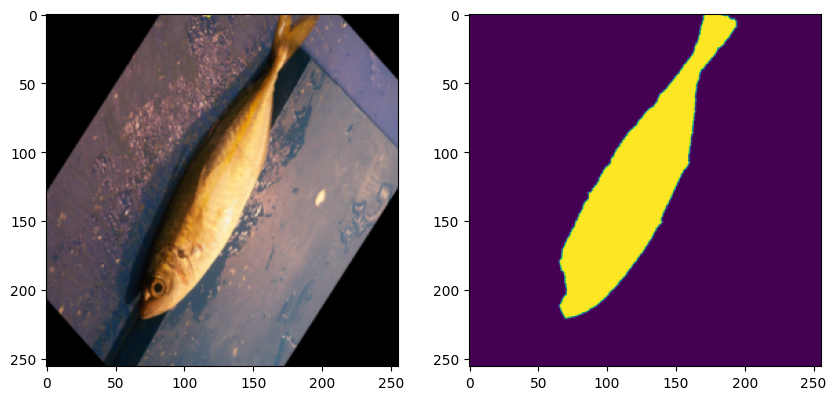

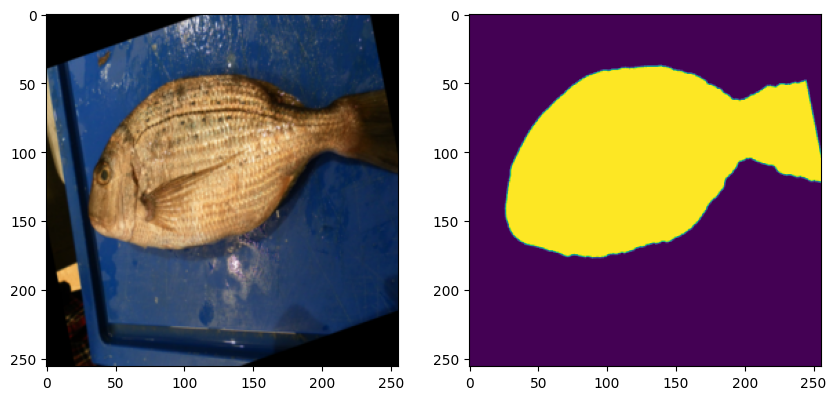

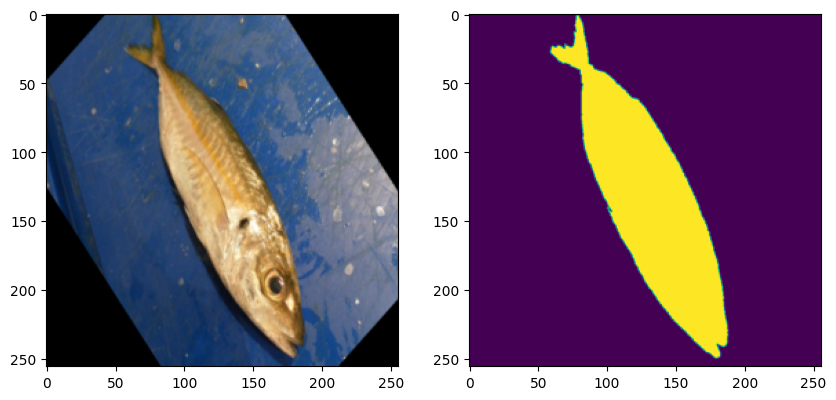

In [10]:
for i in range(3):
    n = random.randint(0, (len(df_train)))
    fig = plt.figure(figsize=(10, 100))
    
    fig.add_subplot(15, 2, 1)
    #plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][0].permute(1, 2, 0))
    
    fig.add_subplot(15, 2, 2)
    #plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][1].permute(1, 2, 0))

## Construindo o Modelo

In [11]:
model = linkNet()
model.to(device, dtype=dtype)

linkNet(
  (_mconv_1): conv_block(
    (_mconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_relu): ReLU(inplace=True)
    )
  )
  (_mmax_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_mencoder_1): encoder(
    (_mres_1): res_block(
      (_mconv_2): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (_mconv_1): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_block_relu): ReLU(inplace=True)
        )
      )
      (_mdownsample

In [12]:
epochs = 30
batch_size = 32
lr = 1e-3
train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(df_valid, batch_size=batch_size, shuffle=False, num_workers=4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [13]:
len(train_loader.dataset)

5400

In [14]:
model, optimizer, train_losses, valid_losses, train_iou_list, valid_iou_list = training_loop(epochs, model, train_loader, valid_loader, criterion, optimizer, device, dtype)

Epoch 1 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:39<00:00,  4.31it/s]


Train loss: 0.2079	Valid loss: 0.0831	Train IoU: 85.44	Valid IoU: 90.54
Epoch 2 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:35<00:00,  4.81it/s]


Train loss: 0.0659	Valid loss: 0.0567	Train IoU: 89.04	Valid IoU: 91.10
Epoch 3 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:32<00:00,  5.26it/s]


Train loss: 0.0498	Valid loss: 0.0497	Train IoU: 89.58	Valid IoU: 88.79
Epoch 4 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:32<00:00,  5.20it/s]


Train loss: 0.0439	Valid loss: 0.0434	Train IoU: 90.04	Valid IoU: 90.15
Epoch 5 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:33<00:00,  5.06it/s]


Train loss: 0.0397	Valid loss: 0.0488	Train IoU: 90.57	Valid IoU: 87.24
Epoch 6 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.76it/s]


Train loss: 0.0382	Valid loss: 0.0562	Train IoU: 90.66	Valid IoU: 85.86
Epoch 7 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.72it/s]


Train loss: 0.0364	Valid loss: 0.0496	Train IoU: 90.77	Valid IoU: 89.19
Epoch 8 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.74it/s]


Train loss: 0.0355	Valid loss: 0.0387	Train IoU: 90.86	Valid IoU: 90.28
Epoch 9 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:30<00:00,  5.54it/s]


Train loss: 0.0329	Valid loss: 0.0403	Train IoU: 91.25	Valid IoU: 91.58
Epoch 10 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.67it/s]


Train loss: 0.0316	Valid loss: 0.0313	Train IoU: 91.34	Valid IoU: 91.61
Epoch 11 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.78it/s]


Train loss: 0.0314	Valid loss: 0.0334	Train IoU: 91.33	Valid IoU: 93.23
Epoch 12 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.82it/s]


Train loss: 0.0308	Valid loss: 0.0346	Train IoU: 91.48	Valid IoU: 92.34
Epoch 13 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.81it/s]


Train loss: 0.0293	Valid loss: 0.0323	Train IoU: 91.58	Valid IoU: 92.46
Epoch 14 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.83it/s]


Train loss: 0.0284	Valid loss: 0.0365	Train IoU: 91.75	Valid IoU: 90.93
Epoch 15 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:30<00:00,  5.47it/s]


Train loss: 0.0278	Valid loss: 0.0297	Train IoU: 91.74	Valid IoU: 92.32
Epoch 16 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.78it/s]


Train loss: 0.0271	Valid loss: 0.0272	Train IoU: 91.80	Valid IoU: 91.87
Epoch 17 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.74it/s]


Train loss: 0.0248	Valid loss: 0.0262	Train IoU: 92.19	Valid IoU: 92.88
Epoch 18 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.79it/s]


Train loss: 0.0242	Valid loss: 0.0286	Train IoU: 92.32	Valid IoU: 93.89
Epoch 19 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.74it/s]


Train loss: 0.0236	Valid loss: 0.0269	Train IoU: 92.36	Valid IoU: 92.93
Epoch 20 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.76it/s]


Train loss: 0.0237	Valid loss: 0.0301	Train IoU: 92.35	Valid IoU: 91.86
Epoch 21 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.80it/s]


Train loss: 0.0227	Valid loss: 0.0294	Train IoU: 92.58	Valid IoU: 94.02
Epoch 22 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.75it/s]


Train loss: 0.0218	Valid loss: 0.0274	Train IoU: 92.75	Valid IoU: 94.07
Epoch 23 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.78it/s]


Train loss: 0.0229	Valid loss: 0.0630	Train IoU: 92.48	Valid IoU: 86.32
Epoch 24 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.72it/s]


Train loss: 0.0200	Valid loss: 0.0220	Train IoU: 93.11	Valid IoU: 93.18
Epoch 25 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.64it/s]


Train loss: 0.0202	Valid loss: 0.0250	Train IoU: 93.05	Valid IoU: 92.25
Epoch 26 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:30<00:00,  5.54it/s]


Train loss: 0.0217	Valid loss: 0.0242	Train IoU: 92.81	Valid IoU: 92.55
Epoch 27 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.63it/s]


Train loss: 0.0192	Valid loss: 0.0208	Train IoU: 93.26	Valid IoU: 93.72
Epoch 28 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:30<00:00,  5.58it/s]


Train loss: 0.0194	Valid loss: 0.0214	Train IoU: 93.19	Valid IoU: 94.07
Epoch 29 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:31<00:00,  5.44it/s]


Train loss: 0.0185	Valid loss: 0.0223	Train IoU: 93.37	Valid IoU: 94.93
Epoch 30 out of 30


100%|██████████████████████████████████████████████████| 169/169 [00:29<00:00,  5.66it/s]


Train loss: 0.0187	Valid loss: 0.0270	Train IoU: 93.35	Valid IoU: 92.45


In [15]:
torch.save(model.state_dict(), "linknet.pkl")

### Carregando Modelo

In [12]:
model.load_state_dict(torch.load("linknet.pkl"))

<All keys matched successfully>

## Avaliando o Modelo

In [16]:
test_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
model.eval()
model.to(device)

linkNet(
  (_mconv_1): conv_block(
    (_mconv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_relu): ReLU(inplace=True)
    )
  )
  (_mmax_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_mencoder_1): encoder(
    (_mres_1): res_block(
      (_mconv_2): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (_mconv_1): conv_block(
        (_mconv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_block_relu): ReLU(inplace=True)
        )
      )
      (_mdownsample

In [18]:
img_list_test = list(df_test_pd['image'])
mask_list_test = list(df_test_pd['mask'])

In [21]:
running_iou = 0

for i in range(len(img_list_test)):
    image = cv2.imread(img_list_test[i])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    iou_pred = iou_np(mask, pred)
    running_iou += iou_pred

iou_test = (running_iou / len(img_list_test)) * 100
print(f'IoU: {iou_test:.1f}')

IoU: 92.9


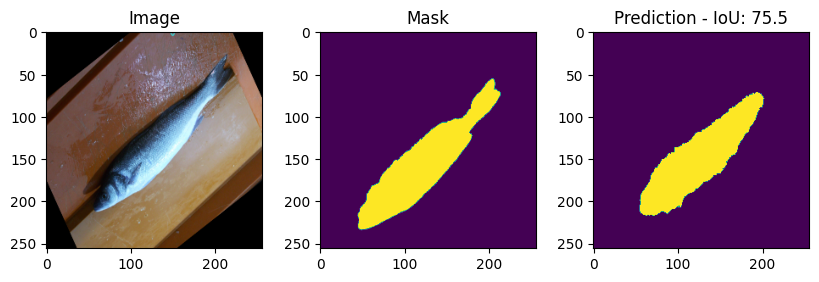

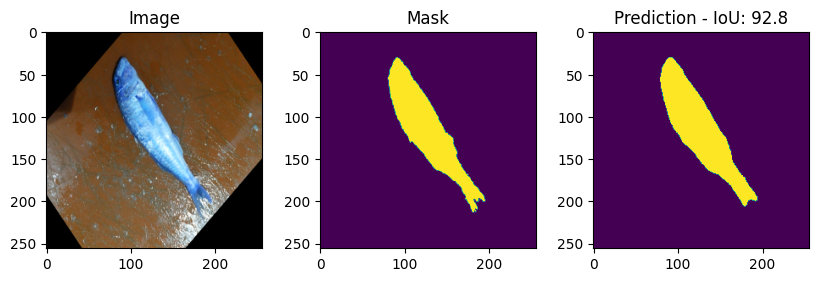

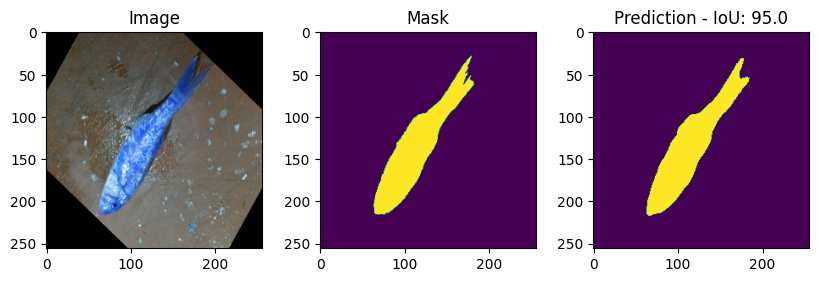

In [23]:
for i in range(3):
    n = random.randint(0, (len(img_list_test)))
    fig = plt.figure(figsize=(10, 50))
    
    image = cv2.imread(img_list_test[n])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[n])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    iou = iou_np(mask, pred) * 100
    
    
    fig.add_subplot(15, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    
    fig.add_subplot(15, 3, 2)
    plt.title('Mask')
    plt.imshow(mask)
    
    fig.add_subplot(15, 3, 3)
    plt.title(f'Prediction - IoU: {iou:.1f}')
    plt.imshow(pred)

## Teste Foto Gil

Text(0.5, 1.0, 'Prediction')

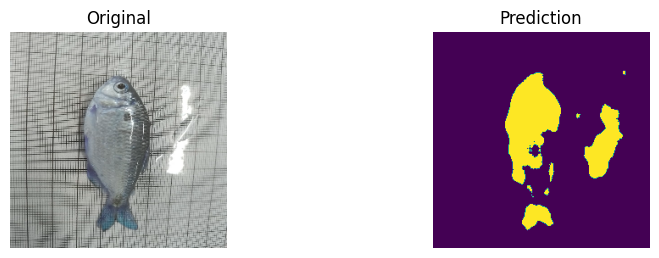

In [24]:
fig = plt.figure(figsize=(10, 50))
image = cv2.imread('peixe.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (img_size, img_size))
pred = predict(model, image, img_size, threshold, device)
#iou = iou_np(mask, pred) * 100

fig.add_subplot(15, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original')

fig.add_subplot(15, 2, 2)
plt.imshow(pred)
plt.axis('off')
plt.title('Prediction')